In [1]:
from networks import *
from simulation import *
from display import *
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# Refutation of Pastor-Satorras and Vespignani (2000)

*With the following, I intend to show a critical fault in the work of Pastor-Satorras and Vespignani on epidemic spreading in scale-free networks.*

I postulate that even in BA graphs (which are scale-free) virus survival is critical on it's infection rate and are not qualitatively different than ER or WS graphs in this regard.

To begin, we establish that viral survival in ER and WS graphs is indeed critical:

# ER Graphs

In [67]:
def test_graph_topology(graph_type, network_size, lams, trials, time_steps):
    criticality_data = []
    for l, lam in enumerate(lams):
        print(l, 'lam:', lam)
        rhoss = []
        cum_rhos = []
        for _ in range(trials):
            if graph_type is 'er':
                g = gen_ER_graph(network_size, 6/(network_size-1), alt=True)
            elif graph_type is 'ws':
                g = gen_WS_graph(network_size, 3, 0.01)
            elif graph_type is 'ba':
                g = gen_BA_graph(network_size, 3)
            
            # rhos is a timeseries of the infection fraction
            # cum_rho is the set of all nodes infected in the simulation
            rhos, cum_rho = run_SIS_simulation(g, lam, rho_0=0.01, time_steps=time_steps)
            
            rhoss.append(rhos)
            cum_rhos.append(cum_rho)
            
        criticality_data.append((lam, np.array(rhoss), np.array(cum_rhos)))
    print('done')
    return criticality_data

In [68]:
network_size = 5000

In [77]:
lams1 = np.linspace(0.07, 0.09, 10)
er_criticality_data = test_graph_topology('er', network_size, lams1, 40, 100)

0 lam: 0.07
1 lam: 0.0722222222222
2 lam: 0.0744444444444
3 lam: 0.0766666666667
4 lam: 0.0788888888889
5 lam: 0.0811111111111
6 lam: 0.0833333333333
7 lam: 0.0855555555556
8 lam: 0.0877777777778
9 lam: 0.09
done


In [56]:
import pickle
pickle.dump(er_criticality_data, open('er_criticality_data.pickle', 'wb'))

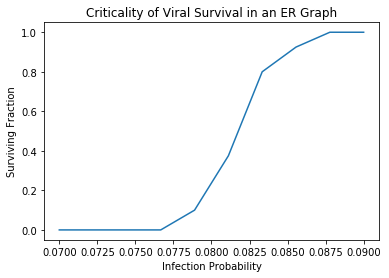

In [57]:
data = pickle.load(open('er_criticality_data.pickle', 'rb'))

survival_data = []
lams = []
for lam, rhoss, cum_rhos in data:
    surviving = rhoss[:,-1] > 0
    survival_data.append(sum(surviving) / len(surviving))
    lams.append(lam)

plt.plot(lams, survival_data)
plt.ylabel('Surviving Fraction')
plt.xlabel('Infection Probability')
plt.title('Criticality of Viral Survival in an ER Graph')

Above we see a critical threshold `lambda_c ~ 0.08` for the survival of the virus

We also verify that when the virus survives, it floods the network as claimed. We cannot simply check that the viral infection fraction is close to 1.0 in the steady state because of the nature of our simulation. Even when lambda = 1.0, we expect only half the network to be infected at any given time since an infected node must recover before being infected again. Lowering lambda leads to lower infection fractions, but not necessarily unaffected portions of the network. Instead we evaluate flooding by examining the fraction of nodes which have been infected over the course of the virus' life `cum_rho` for "cumulative rho". Here the behavior is a bit more consistent so I have chosen to decrease the number of trials in favor of a longer number of time steps simulated.

In [83]:
lams2 = np.linspace(0.07, 0.09, 10)
er_criticality_data_flood = test_graph_topology('er', network_size, lams2, 10, 1000)

0 lam: 0.07
1 lam: 0.0722222222222
2 lam: 0.0744444444444
3 lam: 0.0766666666667
4 lam: 0.0788888888889
5 lam: 0.0811111111111
6 lam: 0.0833333333333
7 lam: 0.0855555555556
8 lam: 0.0877777777778
9 lam: 0.09
done


In [75]:
import pickle
pickle.dump(er_criticality_data_flood, open('er_criticality_data_flood.pickle', 'wb'))

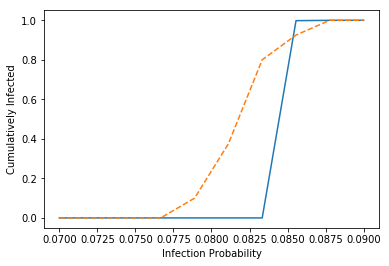

In [76]:
data = pickle.load(open('er_criticality_data_flood.pickle', 'rb'))

cum_inf_data = []
lams2 = []
for lam, rhoss, cum_rhos in data:
    cum_rhos_select = []  # only use trials which survive
    for rhos, cum_rho in zip(rhoss, cum_rhos):
        if rhos[-1] > 0:
            cum_rhos_select.append(cum_rho)
    if cum_rhos_select:
        cum_inf_count = sum(len(cr) for cr in cum_rhos_select) / (network_size * len(cum_rhos_select))
    else:
        cum_inf_count = 0

    cum_inf_data.append(cum_inf_count)
    lams2.append(lam)

plt.plot(lams2, cum_inf_data)
plt.plot(lams1, survival_data, '--')
plt.ylabel('Cumulatively Infected')
plt.xlabel('Infection Probability')

Shown above are data for the cumulative infection over 1000 time steps as compared to the survival probability. Note that cumulative rates are only shown for virus trials where the virus does not die out, as we are trying to assess whether viable viruses become epidemics.

# WS Graphs

In [84]:
lams1 = np.linspace(0.5, 0.7, 10)
ws_criticality_data = test_graph_topology('ws', network_size, lams1, 40, 100)

0 lam: 0.5
1 lam: 0.522222222222
2 lam: 0.544444444444
3 lam: 0.566666666667
4 lam: 0.588888888889
5 lam: 0.611111111111
6 lam: 0.633333333333
7 lam: 0.655555555556
8 lam: 0.677777777778
9 lam: 0.7
done


In [81]:
import pickle
pickle.dump(ws_criticality_data, open('ws_criticality_data.pickle', 'wb'))

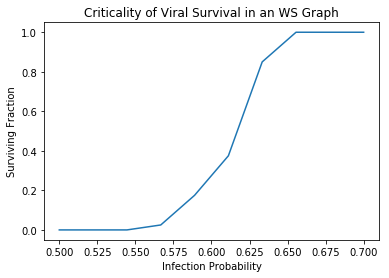

In [82]:
data = pickle.load(open('ws_criticality_data.pickle', 'rb'))

survival_data = []
lams1 = []
for lam, rhoss, cum_rhos in data:
    surviving = rhoss[:,-1] > 0
    survival_data.append(sum(surviving) / len(surviving))
    lams1.append(lam)

plt.plot(lams1, survival_data)
plt.ylabel('Surviving Fraction')
plt.xlabel('Infection Probability')
plt.title('Criticality of Viral Survival in an WS Graph')

Above we see a critical threshold `lambda_c ~ 0.62` for the survival of the virus in WS graph

We check for network flooding in the same manner as with ER graphs:

In [2]:
lams2 = np.linspace(0.5, 0.8, 10)
ws_criticality_data_flood = test_graph_topology('ws', network_size, lams2, 10, 1000)

0 lam: 0.5
1 lam: 0.533333333333
2 lam: 0.566666666667
3 lam: 0.6
4 lam: 0.633333333333
5 lam: 0.666666666667
6 lam: 0.7
7 lam: 0.733333333333
8 lam: 0.766666666667
9 lam: 0.8


In [3]:
import pickle
pickle.dump(ws_criticality_data_flood, open('ws_criticality_data_flood.pickle', 'wb'))

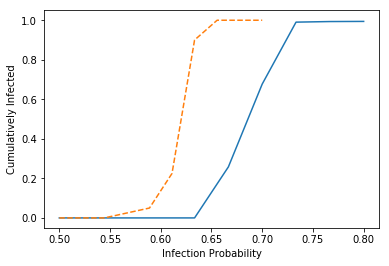

In [8]:
data = pickle.load(open('ws_criticality_data_flood.pickle', 'rb'))

cum_inf_data = []
lams2 = []
for lam, rhoss, cum_rhos in data:
    cum_rhos_select = []  # only use trials which survive
    for rhos, cum_rho in zip(rhoss, cum_rhos):
        if rhos[-1] > 0:
            cum_rhos_select.append(cum_rho)
    if cum_rhos_select:
        cum_inf_count = sum(len(cr) for cr in cum_rhos_select) / (network_size * len(cum_rhos_select))
    else:
        cum_inf_count = 0
    cum_inf_data.append(cum_inf_count)
    lams2.append(lam)

plt.plot(lams2, cum_inf_data)
plt.plot(lams1, survival_data, '--')
plt.ylabel('Cumulatively Infected')
plt.xlabel('Infection Probability')


Above we find that the cumulative infection fraction has a higher critical value than that for survival, which seems off to me right now. [TODO]

# BA Graphs

In [85]:
lams1 = np.linspace(0.07, 0.12, 10)
ba_criticality_data = test_graph_topology('ba', network_size, lams1, 40, 100)

0 lam: 0.07
1 lam: 0.0755555555556
2 lam: 0.0811111111111
3 lam: 0.0866666666667
4 lam: 0.0922222222222
5 lam: 0.0977777777778
6 lam: 0.103333333333
7 lam: 0.108888888889
8 lam: 0.114444444444
9 lam: 0.12
done


In [86]:
import pickle
pickle.dump(ba_criticality_data, open('ba_criticality_data.pickle', 'wb'))

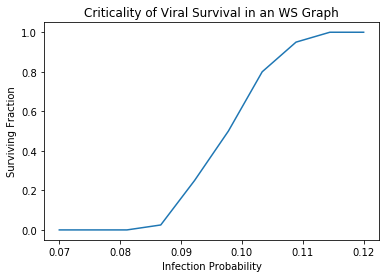

In [87]:
data = pickle.load(open('ba_criticality_data.pickle', 'rb'))

survival_data = []
lams1 = []
for lam, rhoss, cum_rhos in data:
    surviving = rhoss[:,-1] > 0
    survival_data.append(sum(surviving) / len(surviving))
    lams1.append(lam)

plt.plot(lams1, survival_data)
plt.ylabel('Surviving Fraction')
plt.xlabel('Infection Probability')
plt.title('Criticality of Viral Survival in an WS Graph')

Above we see a critical threshold `lambda_c ~ 0.10` for the survival of the virus in a BA graph, only quantitatively different from WS and ER. Of course, we must also check that the network truly floods at this critical point.

We check for network flooding in the same manner as with the other two types of graphs:

In [88]:
lams2 = np.linspace(0.07, 0.12, 20)
ba_criticality_data_flood = test_graph_topology('ba', network_size, lams2, 10, 1000)

0 lam: 0.07
1 lam: 0.0726315789474
2 lam: 0.0752631578947
3 lam: 0.0778947368421
4 lam: 0.0805263157895
5 lam: 0.0831578947368
6 lam: 0.0857894736842
7 lam: 0.0884210526316
8 lam: 0.0910526315789
9 lam: 0.0936842105263
10 lam: 0.0963157894737
11 lam: 0.0989473684211
12 lam: 0.101578947368
13 lam: 0.104210526316
14 lam: 0.106842105263
15 lam: 0.109473684211
16 lam: 0.112105263158
17 lam: 0.114736842105
18 lam: 0.117368421053
19 lam: 0.12
done


In [89]:
import pickle
pickle.dump(ba_criticality_data_flood, open('ba_criticality_data_flood.pickle', 'wb'))

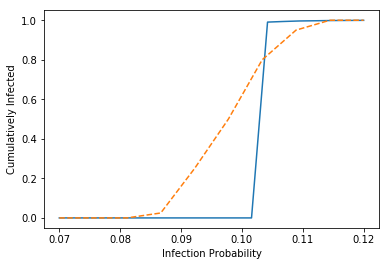

In [90]:
data = pickle.load(open('ba_criticality_data_flood.pickle', 'rb'))

cum_inf_data = []
lams2 = []
for lam, rhoss, cum_rhos in data:
    cum_rhos_select = []  # only use trials which survive
    for rhos, cum_rho in zip(rhoss, cum_rhos):
        if rhos[-1] > 0:
            cum_rhos_select.append(cum_rho)
    if cum_rhos_select:
        cum_inf_count = sum(len(cr) for cr in cum_rhos_select) / (network_size * len(cum_rhos_select))
    else:
        cum_inf_count = 0
    cum_inf_data.append(cum_inf_count)
    lams2.append(lam)

plt.plot(lams2, cum_inf_data)
plt.plot(lams1, survival_data, '--')
plt.ylabel('Cumulatively Infected')
plt.xlabel('Infection Probability')


It would appear that there is an epidemic threshold and that it is close to the survival threshold as in ER graphs. 

All of this would lead one to believe that it is in fact the WS small-world graph which is the qualitative outlier here with a small range of infection rates which yield viral survival but viral pervasiveness. This is quite different than the findings suggested in Pastor-Satorras and Vespignani (2000). 

##### The rest of this notebook is here for historical purposes

This next bit is important:

Even though the end infection fraction is very small, we say the network is flooded because almost all nodes are infected in the last 100 time steps of the simulation.

0.1 0.0045701010101 3954
0.1075 0.00428363636364 3906
0.115 0.0147171717172 4915
0.1225 0.0190719191919 4962
0.13 0.0231175757576 4990


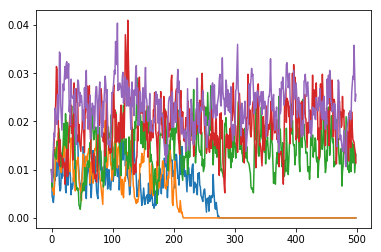

In [74]:
lams = np.linspace(0.1, 0.13, 5)
for lam in lams:
    g = gen_BA_graph(5000, 3)
    rhos, cum_rho = run_SIS_simulation(g, lam, rho_0=0.01, time_steps=500)
    print(lam, np.mean(rhos[5:]), len(cum_rho))
    plt.plot(rhos)

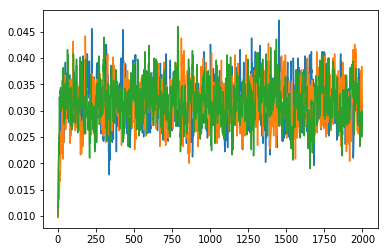

In [32]:
g = gen_ER_graph(5000, 6/(5000-1), alt=True)
trials = 3
lam = 0.1
rhoss = []
tails = []
for _ in range(trials):
    rhos, tail = run_SIS_simulation(g, lam, rho_0=0.01, time_steps=2000)
    rhoss.append(rhos)
    tails.append(tail)
for rhos in rhoss:
    plt.plot(rhos)

In [109]:
lams = np.linspace(0.02, 1.0, 20)
trials = 20
sss = []
for lam in lams:
    print(lam)
    g = gen_ER_graph(5000, 6/(5000-1), alt=True)
    ss = np.mean([np.mean(run_SIS_simulation(g, lam, time_steps=15)[5:]) for _ in range(trials)])
    sss.append(ss)

0.02
0.0715789473684
0.123157894737
0.174736842105


KeyboardInterrupt: 

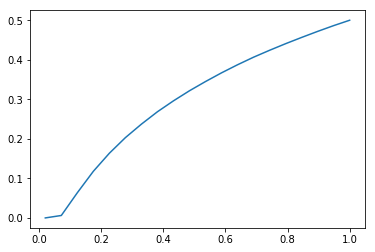

In [55]:
plt.plot(lams, sss)

In [56]:
lams = np.linspace(0.02, 1.0, 20)
trials = 20
sss = []
for lam in lams:
    print(lam)
    g = gen_WS_graph(5000, 3, 0.2)
    ss = np.mean([np.mean(run_SIS_simulation(g, lam, time_steps=15)[5:]) for _ in range(trials)])
    sss.append(ss)

0.02
0.0715789473684
0.123157894737
0.174736842105
0.226315789474
0.277894736842
0.329473684211
0.381052631579
0.432631578947
0.484210526316
0.535789473684
0.587368421053
0.638947368421
0.690526315789
0.742105263158
0.793684210526
0.845263157895
0.896842105263
0.948421052632
1.0


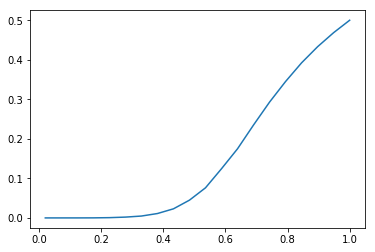

In [57]:
plt.plot(lams, sss)

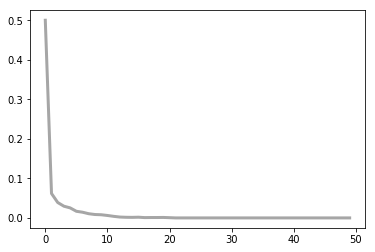

In [46]:
rhos1 = run_SIS_simulation(g1, 0.13, time_steps=50)
plot_all_time_steps(rhos1)

In [26]:
for lam in np.linspace(0, 1, 5):
    print(run_SIS_simulation(g, 0.1))

[  5.00000000e-01   5.18000000e-02   2.38000000e-02   2.70000000e-02
   2.10000000e-02   1.18000000e-02   1.06000000e-02   8.60000000e-03
   9.00000000e-03   1.22000000e-02   1.22000000e-02   7.40000000e-03
   8.00000000e-03   7.80000000e-03   6.00000000e-03   3.80000000e-03
   3.20000000e-03   2.80000000e-03   4.20000000e-03   4.20000000e-03
   2.60000000e-03   4.20000000e-03   7.80000000e-03   8.00000000e-03
   1.00000000e-02   8.20000000e-03   8.20000000e-03   1.34000000e-02
   1.36000000e-02   1.52000000e-02   1.40000000e-02   1.30000000e-02
   7.40000000e-03   8.00000000e-03   1.00000000e-02   8.40000000e-03
   8.00000000e-03   9.20000000e-03   1.40000000e-02   1.26000000e-02
   1.04000000e-02   8.60000000e-03   7.20000000e-03   3.20000000e-03
   7.80000000e-03   6.40000000e-03   8.40000000e-03   6.00000000e-03
   3.80000000e-03   4.40000000e-03   1.80000000e-03   2.40000000e-03
   1.20000000e-03   8.00000000e-04   8.00000000e-04   8.00000000e-04
   5.60000000e-03   6.20000000e-03

[  5.00000000e-01   4.92000000e-02   1.82000000e-02   1.28000000e-02
   1.16000000e-02   1.16000000e-02   5.80000000e-03   5.00000000e-03
   5.80000000e-03   5.80000000e-03   5.40000000e-03   5.80000000e-03
   5.60000000e-03   7.00000000e-03   6.40000000e-03   6.60000000e-03
   8.00000000e-03   8.20000000e-03   1.10000000e-02   1.40000000e-02
   9.60000000e-03   9.40000000e-03   8.40000000e-03   7.40000000e-03
   7.80000000e-03   5.40000000e-03   4.60000000e-03   3.80000000e-03
   2.60000000e-03   2.20000000e-03   2.60000000e-03   3.80000000e-03
   3.40000000e-03   2.20000000e-03   1.20000000e-03   4.00000000e-04
   6.00000000e-04   4.00000000e-04   4.00000000e-04   1.00000000e-03
   2.20000000e-03   3.60000000e-03   9.80000000e-03   7.60000000e-03
   8.20000000e-03   6.20000000e-03   5.40000000e-03   1.16000000e-02
   8.80000000e-03   6.80000000e-03   8.80000000e-03   1.24000000e-02
   9.20000000e-03   1.00000000e-02   1.50000000e-02   1.62000000e-02
   1.54000000e-02   1.46000000e-02

In [1]:
g = gen_BA_graph(100000, 3)
data = run_SIS_simulation(g, .05, rho_0=0.1, time_steps=50)
plot_all_time_steps(data)

NameError: name 'gen_BA_graph' is not defined

# Experiment 1

In [8]:
lambdas_plan = {
    1e5 : np.linspace(1/12, 1/8, 5),
    5e5 : np.linspace(1/15, 1/10, 3),
    1e6 : np.linspace(1/17, 1/12, 2),
    5e6 : np.linspace(1/18, 1/15, 2),
    8.5e6 : np.linspace(1/20, 1/19, 2),
#     8.5e6 : [1/20]
}

data = {}
for size in lambdas_plan.keys():
    print('starting size: ', size)
    g = gen_BA_graph(size, 3)
    for lam in lambdas_plan[size]:
        print('\tstarting lamda: ', lam)
        data[(size, lam)] = []
        for trial in range(10):
#             print('t', trial)
            data[(size, lam)].append(run_SIS_simulation(g, lam, time_steps=20)[-1])
        data[(size, lam)] = np.mean(data[(size, lam)])

starting size:  100000.0
	starting lamda:  0.0833333333333
	starting lamda:  0.09375
	starting lamda:  0.104166666667
	starting lamda:  0.114583333333
	starting lamda:  0.125
starting size:  500000.0
	starting lamda:  0.0666666666667
	starting lamda:  0.0833333333333
	starting lamda:  0.1
starting size:  1000000.0
	starting lamda:  0.0588235294118
	starting lamda:  0.0833333333333
starting size:  5000000.0
	starting lamda:  0.0555555555556
	starting lamda:  0.0666666666667
starting size:  8500000.0
	starting lamda:  0.05
	starting lamda:  0.0526315789474


In [5]:
import pickle

In [22]:
pickle.dump(data, open('big_data.pickle', 'wb'))

In [21]:
# d = pickle.load(open('big_data.pickle', 'rb'))

In [27]:
plottable_data = {}
for size, lam in data:
    plottable_data[size] = plottable_data.get(size, []) + [(1.0/lam, data[(size, lam)])]

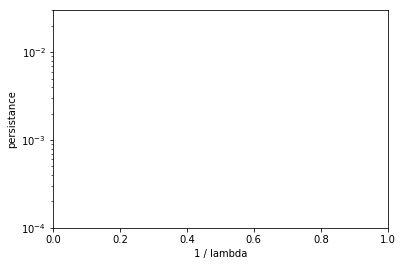

# Plot No. 1

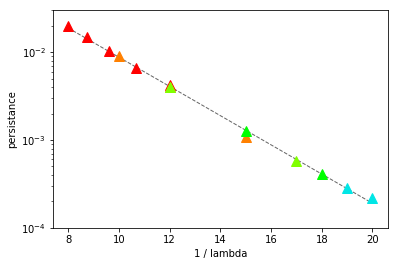

In [148]:
# plot a fit
all_xs = []
all_ys = []
for values in plottable_data.values():
    xs, ys = zip(*values)
    all_xs.extend(xs)
    all_ys.extend(ys)
    
a, c = np.polyfit(all_xs, np.log(all_ys), 1)
fit_xs = np.linspace(8, 20, 100)
fit_ys = np.exp(a * fit_xs + c)
thinkplot.plot(fit_xs, fit_ys, style='--', linewidth=1, color=(.4,.4,.4), alpha=1.0)


# plot a 
shapes = ['o', '+', 's', 'x', 'v', '.']
colors = [(1., 0., 0.), (1., .5, 0.), (.5, 1., 0.), (0., 1., 0.), (0., .9, .9)]

for size, shape, color in zip(plottable_data, shapes, colors):
    xs, ys = zip(*plottable_data[size])
    thinkplot.plot(xs, ys, style='^', color=color, markersize=10, alpha=1.0)
    

thinkplot.config(ylim=[1e-4, 3e-2], yscale='log', xlabel='1 / lambda', ylabel='persistance')

plt.savefig('takes_a_while.pdf')

# Experiment 2

In [5]:
sizes = [500000, 25000, 12500, 6250]

lam = 0.065
trials = 100000
ts = 50

In [27]:


data = {}

for size in sizes:
    print('starting size ', size)
    surviving_strains = np.zeros(ts, dtype=np.int32)  # how many trials are surviving at time t
    g = gen_BA_graph(size, 3)
    for trial in range(trials):
        if trial % 1000 == 0:
            print('starting trial ', trial)
        surviving_strains += np.array([bool(rho) for rho in run_SIS_simulation(g, lam, rho_0=None, time_steps=ts)])

    data[size] = surviving_strains

starting size  500000
starting trial  0
starting trial  1000
starting trial  2000
starting trial  3000
starting trial  4000
starting trial  5000
starting trial  6000
starting trial  7000
starting trial  8000
starting trial  9000
starting trial  10000
starting trial  11000
starting trial  12000
starting trial  13000
starting trial  14000
starting trial  15000
starting trial  16000
starting trial  17000
starting trial  18000
starting trial  19000
starting trial  20000
starting trial  21000
starting trial  22000
starting trial  23000
starting trial  24000
starting trial  25000
starting trial  26000
starting trial  27000
starting trial  28000
starting trial  29000
starting trial  30000
starting trial  31000
starting trial  32000
starting trial  33000
starting trial  34000
starting trial  35000
starting trial  36000
starting trial  37000
starting trial  38000
starting trial  39000
starting trial  40000
starting trial  41000
starting trial  42000
starting trial  43000
starting trial  44000
s

starting trial  72000
starting trial  73000
starting trial  74000
starting trial  75000
starting trial  76000
starting trial  77000
starting trial  78000
starting trial  79000
starting trial  80000
starting trial  81000
starting trial  82000
starting trial  83000
starting trial  84000
starting trial  85000
starting trial  86000
starting trial  87000
starting trial  88000
starting trial  89000
starting trial  90000
starting trial  91000
starting trial  92000
starting trial  93000
starting trial  94000
starting trial  95000
starting trial  96000
starting trial  97000
starting trial  98000
starting trial  99000


In [2]:
pickle.dump(data, open('change.pickle', 'wb'))

NameError: name 'pickle' is not defined

# Plot 2

In [6]:
data2 = pickle.load(open('survival-effing-good.pickle', 'rb'))
for size in data2:
    thinkplot.plot(range(0, ts), data2[size]/trials, style='o-', markersize=3, linewidth=1)
    
thinkplot.config(ylim=[2e-4, 2], yscale='log', xlabel='t', ylabel='surviving probability')
plt.savefig('takes_a_long_while.pdf')

NameError: name 'plt' is not defined